In [3]:
# Import libraries

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from shapely.geometry import Point

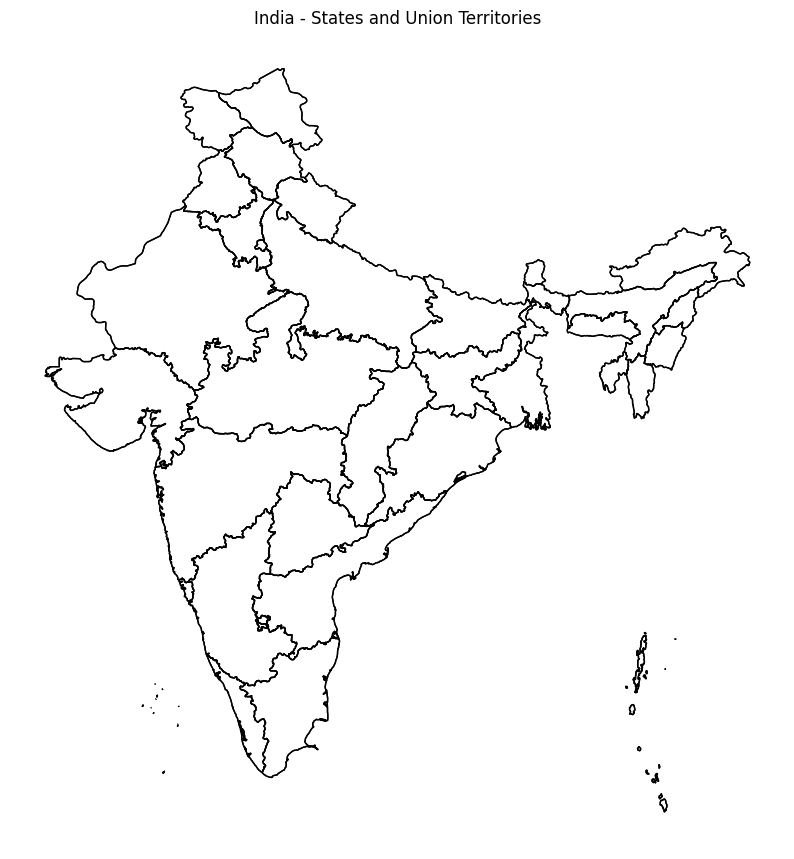

In [4]:
# load shapefile and filter for Indian States
gdf = gpd.read_file('ne_10m_admin_1_states_provinces.shp')
india_states = gdf[gdf['admin'] == 'India']

# Plot India with State boundaries
fig, ax = plt.subplots(figsize=(10, 12))
india_states.boundary.plot(ax=ax, linewidth=1, color='black')
india_states.plot(ax=ax, color='white', edgecolor='black')
ax.set_title('India - States and Union Territories')
ax.axis('off')
plt.show()

In [5]:
# Load and initial filter of pincode data
data = pd.read_csv('clustering_data.csv')
state = "RAJASTHAN"

# Filter for Rajasthan, ignoring case
state_data = data[data['StateName'].str.upper() == state]

# Remove rows with missing coordinates
state_data_clean = state_data[state_data['Longitude'].notna() & state_data['Latitude'].notna()]
print(state_data_clean.shape[0])
print(state_data.head())

10171
           CircleName      RegionName      DivisionName            OfficeName  \
148  Rajasthan Circle  Jodhpur Region   Barmer Division              Akal B.O   
149  Rajasthan Circle  Jodhpur Region   Barmer Division  Daukiyon ka Tala B.O   
150  Rajasthan Circle  Jodhpur Region  Jodhpur Division           NDC Jodhpur   
151  Rajasthan Circle  Jodhpur Region   Barmer Division        Pandarwali B.O   
378  Rajasthan Circle  Jodhpur Region   Barmer Division            Kerawa B.O   

     Pincode OfficeType  Delivery District  StateName   Latitude  Longitude  
148   344704         BO  Delivery   BARMER  RAJASTHAN   24.98773   71.32367  
149   344032         BO  Delivery   BARMER  RAJASTHAN  26.105107  72.175883  
150   342002         PO  Delivery  JODHPUR  RAJASTHAN     26.243     73.021  
151   344706         BO  Delivery   BARMER  RAJASTHAN  24.803237  71.218754  
378   344011         BO  Delivery   BARMER  RAJASTHAN   25.89007  71.150607  


<ipython-input-5-9cfe7ae318d9>:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('clustering_data.csv')


In [6]:
# Coordinate cleaning function
def clean_coordinate(val):
    val = str(val).strip()
    if val.endswith('-'):
        val = '-' + val[:-1]
    val = val.rstrip('ENWSenws°\'"')
    val = re.sub(r'[^0-9\.\-]', '', val)
    try:
        return float(val)
    except ValueError:
        return np.nan

# Apply cleaning to coordinates
state_data_clean = state_data.copy()
state_data_clean.loc[:, 'Longitude'] = state_data_clean['Longitude'].apply(clean_coordinate)
state_data_clean.loc[:, 'Latitude'] = state_data_clean['Latitude'].apply(clean_coordinate)

# Drop any rows where cleaning resulted in NaN
state_data_clean = state_data_clean.dropna(subset=['Longitude', 'Latitude'])

india_states CRS: EPSG:4326
state_points_gdf CRS: EPSG:4326
-122.35 740.06
-3.966995 77.206


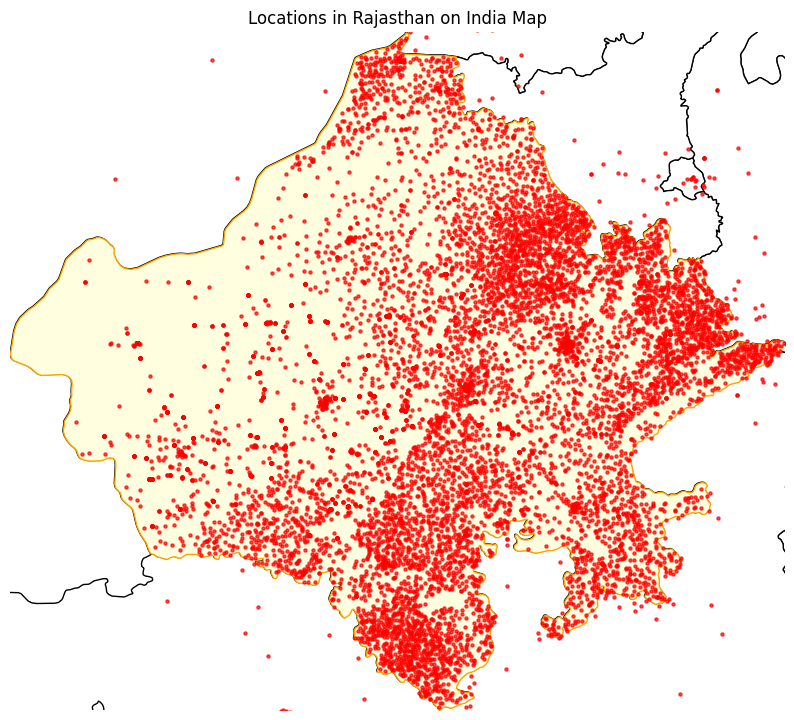

In [7]:
# Create Geodataframe for Rajasthan
state_points_gdf = gpd.GeoDataFrame(
    state_data_clean,
    geometry=gpd.points_from_xy(state_data_clean['Longitude'], state_data_clean['Latitude']), crs="EPSG:4326"
)

print("india_states CRS:", india_states.crs)
print("state_points_gdf CRS:", state_points_gdf.crs)

# Ensure CRS matches
if india_states.crs != "EPSG:4326":
    india_states = india_states.to_crs("EPSG:4326")

# Check coordinate ranges
print(state_points_gdf['Longitude'].min(), state_points_gdf['Longitude'].max())
print(state_points_gdf['Latitude'].min(), state_points_gdf['Latitude'].max())

# Filter points to plausible India bounds
filtered_points_gdf = state_points_gdf[
    (state_points_gdf['Longitude'].between(68, 98)) &
    (state_points_gdf['Latitude'].between(6, 37))
]

# Plot filtered points on India map
fig, ax = plt.subplots(figsize=(10, 12))
india_states.plot(ax=ax, color='white', edgecolor='black')
rajasthan_gdf = india_states[india_states['name'].str.upper() == 'RAJASTHAN']
rajasthan_gdf.plot(ax=ax, color='lightyellow', edgecolor='orange')
filtered_points_gdf.plot(ax=ax, color='red', markersize=5, alpha=0.7)

# Zoom to Rajasthan bounds
minx, miny, maxx, maxy = rajasthan_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_title('Locations in Rajasthan on India Map')
ax.axis('off')
plt.show()

Valid Rajasthan points: 9733


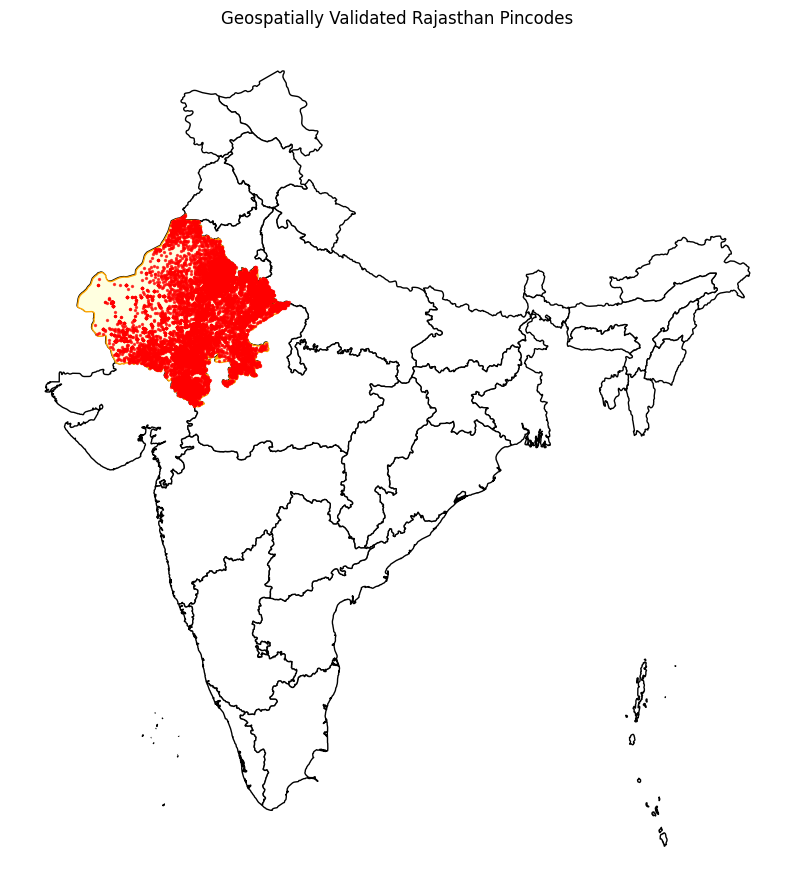

In [8]:
def clean_numeric(val):
    val = str(val)
    if val.endswith('-'):
        val = '-' + val[:-1]
    val = val.rstrip('ENWS').strip()
    return float(re.sub(r'[^0-9\.\-]', '', val)) if re.search(r'\d', val) else np.nan

state_data_clean['Longitude'] = state_data_clean['Longitude'].apply(clean_numeric)
state_data_clean['Latitude'] = state_data_clean['Latitude'].apply(clean_numeric)

state_points_gdf = gpd.GeoDataFrame(
    state_data_clean.dropna(subset=['Longitude', 'Latitude']),
    geometry=gpd.points_from_xy(
        state_data_clean['Longitude'],
        state_data_clean['Latitude']
    ),
    crs="EPSG:4326"
)

rajasthan_gdf = india_states[india_states['name'].str.upper() == 'RAJASTHAN']

# Points within Rajasthan polygon
points_in_rajasthan = gpd.sjoin(
    state_points_gdf,
    rajasthan_gdf,
    how='inner',
    predicate='within'
)

print(f"Valid Rajasthan points: {len(points_in_rajasthan)}")

# Plot only points truly within Rajasthan
fig, ax = plt.subplots(figsize=(10, 12))
india_states.plot(ax=ax, color='white', edgecolor='black')
rajasthan_gdf.plot(ax=ax, color='lightyellow', edgecolor='orange')
points_in_rajasthan.plot(ax=ax, color='red', markersize=2, alpha=0.7)
ax.set_title('Geospatially Validated Rajasthan Pincodes')
ax.axis('off')
plt.show()

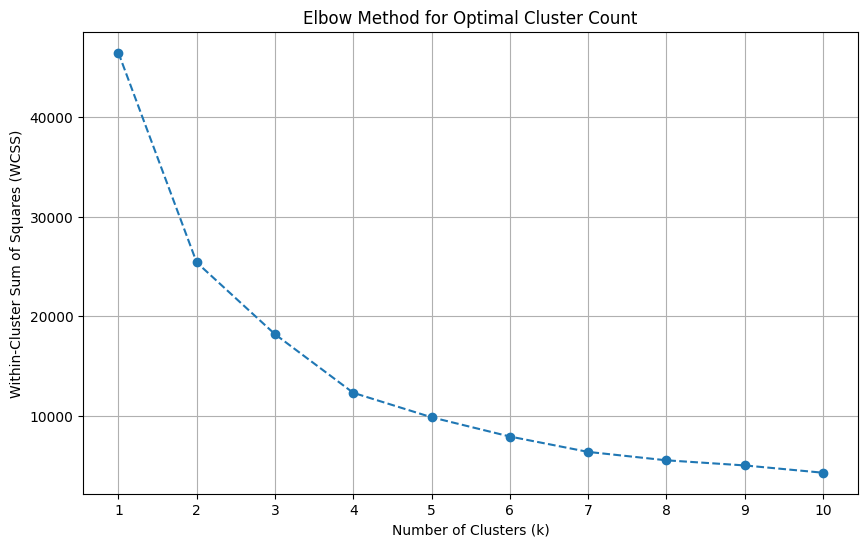

In [9]:
# Prepare data for clustering
X = points_in_rajasthan[['Longitude', 'Latitude']].values

# K-means implementation
def kmeans(X, k, max_iters=100, tol=1e-4):
    np.random.seed(42)
    centroids = X[np.random.choice(len(X), k, replace=False)]
    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, None] - centroids, axis=2)
        clusters = np.argmin(distances, axis=1)
        new_centroids = np.array([X[clusters == i].mean(axis=0) for i in range(k)])
        if np.all(np.linalg.norm(centroids - new_centroids, axis=1) < tol):
            break
        centroids = new_centroids
    return clusters, centroids


# Elbow method to determine optimal value of K
wcss = []
K_range = range(1, 11)


for k in K_range:
    clusters, centroids = kmeans(X, k)
    wcss_k = 0
    for i in range(k):
        cluster_points = X[clusters == i]
        wcss_k += ((cluster_points - centroids[i])**2).sum()
    wcss.append(wcss_k)

plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Cluster Count')
plt.xticks(K_range)
plt.grid(True)
plt.show()


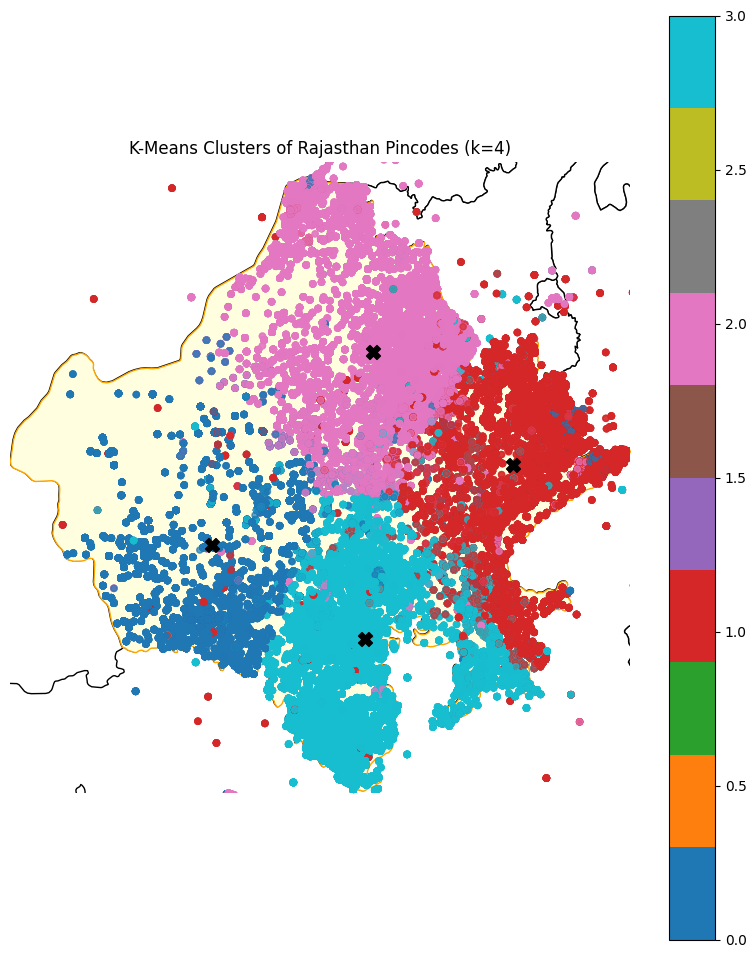

In [10]:
# Final clustering with chosen K
k = 4   # Chosen from elbow plot
clusters, centroids = kmeans(X, k=4)
points_in_rajasthan['cluster'] = clusters


# Merge cluster labels back to all Rajasthan points
state_points_gdf = state_points_gdf.merge(
    points_in_rajasthan[['Pincode', 'cluster']],
    on='Pincode',
    how='left'
)

state_points_gdf['cluster'] = state_points_gdf['cluster'].fillna(-1)

# Visualize clusters on Rajasthan map
fig, ax = plt.subplots(figsize=(10, 12))
india_states.plot(ax=ax, color='white', edgecolor='black')
rajasthan_gdf.plot(ax=ax, color='lightyellow', edgecolor='orange')

# Plot only clustered points (exclude -1)
clustered = state_points_gdf[state_points_gdf['cluster'] != -1]
clustered.plot(
    ax=ax,
    column='cluster',
    cmap='tab10',
    markersize=20,
    alpha=0.7,
    legend=True
)

# Plot centroids
ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='black',
    s=100,
    marker='X',
    label='Centroids'
)

# Zoom to Rajasthan
minx, miny, maxx, maxy = rajasthan_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

ax.set_title('K-Means Clusters of Rajasthan Pincodes (k=4)')
ax.axis('off')
plt.show()